<h1>Practica de Scoring para evaluacion</h1>

In [113]:
#Cargo o importo pandas, numpy, Matplotlib, 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Para el análisis descriptivo inicial de contraste de asociación importo el test Chi2 y el anova 
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway


# Librería para hacer la tramificación, agrupación y transformación WOE
from optbinning import Scorecard, BinningProcess, OptimalBinning
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks, ScorecardMonitoring

# Scikit-learn para dividir la muestra y para estimar el modelo de regresión logística (sólo si no se quiere utilizar
# la función optbinning.scorecard que ya lo incropora)
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.exceptions import FutureWarning

ImportError: cannot import name 'FutureWarning' from 'sklearn.exceptions' (c:\Users\pablo\anaconda3\envs\master_ucm_scoring\Lib\site-packages\sklearn\exceptions.py)

In [4]:
dt=pd.read_excel('DatosPractica_Scoring.xlsx')

<h2>Variable objetivo: Default</h2>

0 si no hizo nunca un impago y 1 si lo hizo.  0 bueno 1 malo

In [ ]:
dt["default"].value_counts()

y
0.0    890
1.0    104
Name: count, dtype: int64

## Inferencia de Denegados

In [ ]:
df = pd.read_excel('DatosPractica_Scoring.xlsx', sheet_name='datospracticas')

# 2. Separar datos aprobados (Cardhldr = 1) y rechazados (Cardhldr = 0)
approved = df[df['Cardhldr'] == 1].copy()
rejected = df[df['Cardhldr'] == 0].copy()

# 3. Preparar datos para modelar con los aprobados
# Eliminar columnas que no son features (y la variable objetivo)
features = approved.drop(['ID', 'Cardhldr', 'default'], axis=1, errors='ignore')
target = approved['default']

# Manejar valores faltantes (si los hay)
features = features.fillna(features.mean())

# 4. Entrenar un modelo de clasificación (usaré RandomForest como ejemplo)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

model =  RandomForestClassifier(class_weight={0:1, 1:10}, random_state=42)
model.fit(X_resampled, y_resampled)

# Evaluar el modelo en los aprobados
print("Evaluación en datos aprobados:")
print(classification_report(y_test, model.predict(X_test)))

# 5. Aplicar el modelo a los clientes rechazados
rejected_features = rejected.drop(['ID', 'Cardhldr', 'default'], axis=1, errors='ignore')
rejected_features = rejected_features.fillna(rejected_features.mean())

# Predecir probabilidades para los rechazados
rejected_probs = model.predict_proba(rejected_features)[:, 1]  # Probabilidad de default

# 6. Hard Cut-Off: Asignar default=1 a los rechazados con alta probabilidad de default
# Definir un umbral (por ejemplo, percentil 90 de probabilidades en aprobados)
approved_probs = model.predict_proba(features)[:, 1]
threshold = np.percentile(approved_probs, 60)  # Ajustar este percentil según necesidad

# Asignar default=1 a los rechazados con probabilidad > threshold
rejected['default'] = (rejected_probs > threshold).astype(int)

# 7. Combinar los datos para crear el dataset aumentado
augmented_df = pd.concat([approved, rejected])


Evaluación en datos aprobados:
              precision    recall  f1-score   support

         0.0       0.96      0.09      0.17       278
         1.0       0.07      0.95      0.14        21

    accuracy                           0.15       299
   macro avg       0.52      0.52      0.15       299
weighted avg       0.90      0.15      0.17       299



c:\Users\pablo\anaconda3\envs\master_ucm_scoring\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


El modelo predictivo me da mal con RandomForest y tambien con regresion logistica, predice muy mal los default=1 y eso es muy riesgoso, seria preferible que prediga mal los default=0, frente a esto voy a poner todos los default en 1.

In [105]:
df = pd.read_excel('DatosPractica_Scoring.xlsx', sheet_name='datospracticas')
df = df.dropna(subset=['Cardhldr'])
df.loc[(df['Cardhldr'] == 0) & (df['default'].isna()), 'default'] = 1

## Analisis exploratorio de las variables

In [106]:
df.rename(columns={"default":"y"},inplace=True)
yT_0 = df['y'].value_counts(normalize=True)[0]
yT_1 = df['y'].value_counts(normalize=True)[1]
print(yT_0, yT_1)
df["y"].value_counts()

0.6926070038910506 0.30739299610894943


y
0.0    890
1.0    395
Name: count, dtype: int64

Como todas las variables predictoras son continuas o booleanas hacemos un analisis exploratorio acorde

### Age

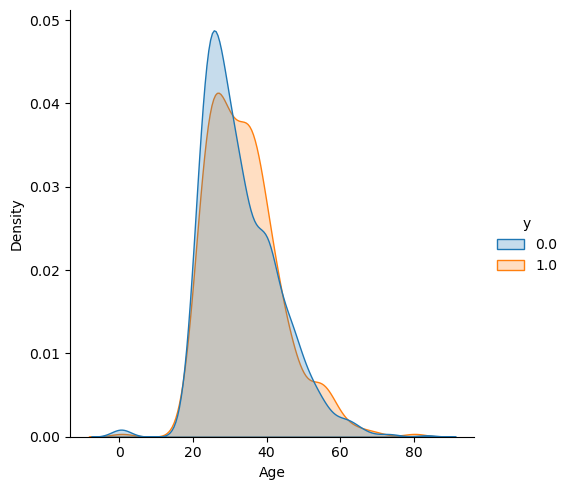

In [78]:
sns.displot(x=(df['Age']), kind="kde", fill=True, hue=df.y, common_norm=False)
plt.show()

Parece tener una distribucion normal dentro de todo pero no aporta mucha informacion

### Income

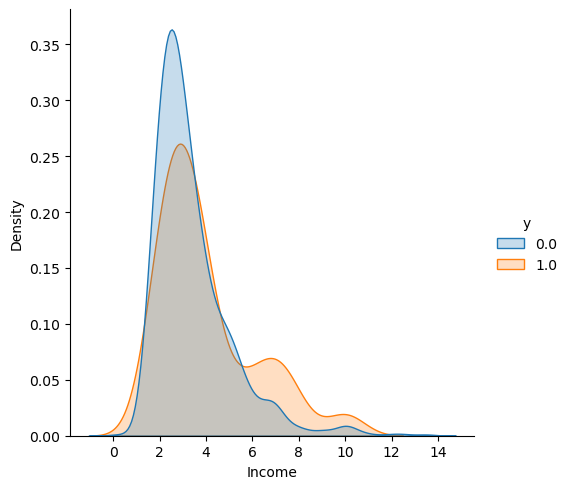

In [80]:
sns.displot(x=(df['Income']), kind="kde", fill=True, hue=dt.y, common_norm=False)
plt.show()

Parece haber una asociacion entre Income y nuestra variable objetivo de bueno o mal pagador. Con menos ingresos hay alog mas buenos pagadores que malos, cuando hay mas ingresos hay bastante mas malos pagadores que buenos. En terminos generales igual hay significativamente mas gente con menos ingresos que con muchos ingresos

### Exp_Inc

Ratio of monthly credit card expenditure to yearly income

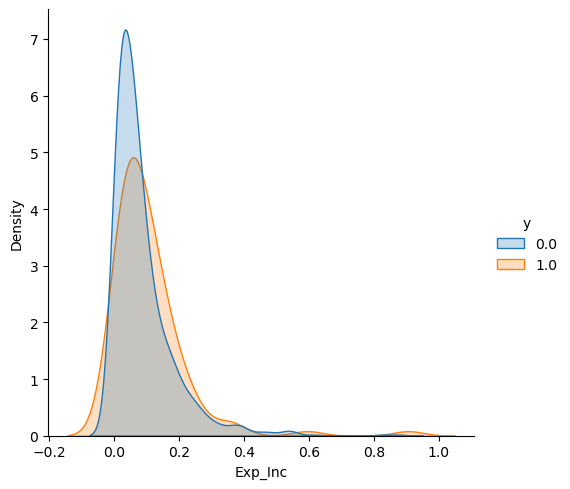

In [81]:
sns.displot(x=(df['Exp_Inc']), kind="kde", fill=True, hue=dt.y, common_norm=False)
plt.show()

Esta variable no aporta mucha informacion incluso transformada, los malos y buenos pagadores estan practicamente solapados.

### Avgexp

Average monthly credit card expenditure 

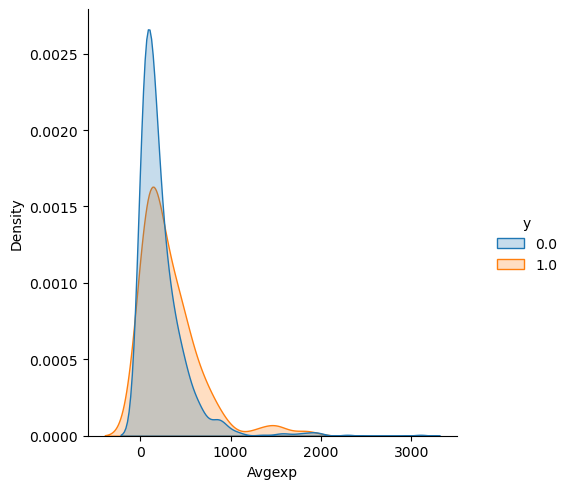

In [82]:
sns.displot(x=(df['Avgexp']), kind="kde", fill=True, hue=dt.y, common_norm=False)
plt.show()

realmente no aparece haber demasiada informacion predictora en esta variable , los valores estan totalmente solapados aunque los buenos pagadores estan bastante mas concentrados en la derecha que los malos pagadores

### Depndt

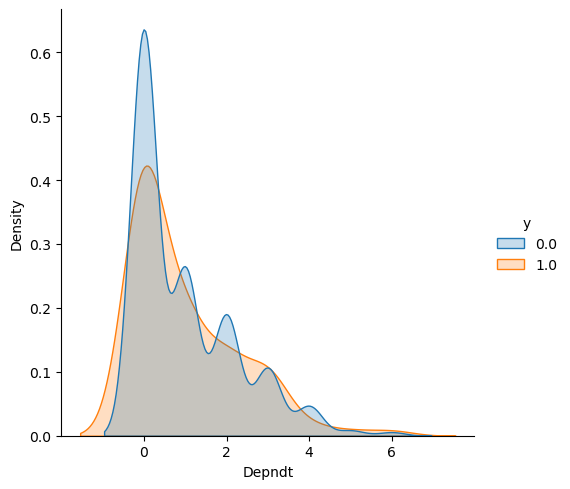

In [85]:
sns.displot(x=(df['Depndt']), kind="kde", fill=True, hue=dt.y, common_norm=False)
plt.show()

### Inc_per

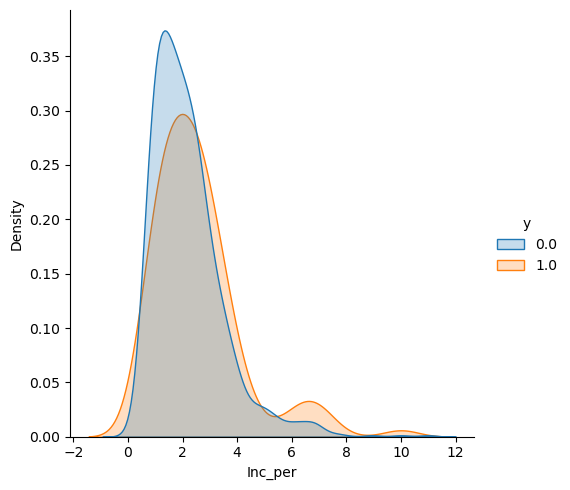

In [83]:
sns.displot(x=(df['Inc_per']), kind="kde", fill=True, hue=dt.y, common_norm=False)
plt.show()

aporta cierta informacion si es que el income esta dividio por 6 o mas, pero deben ser muy pocas muestras en esos escenarios no se si es informacion muy fiable

### Cur_add

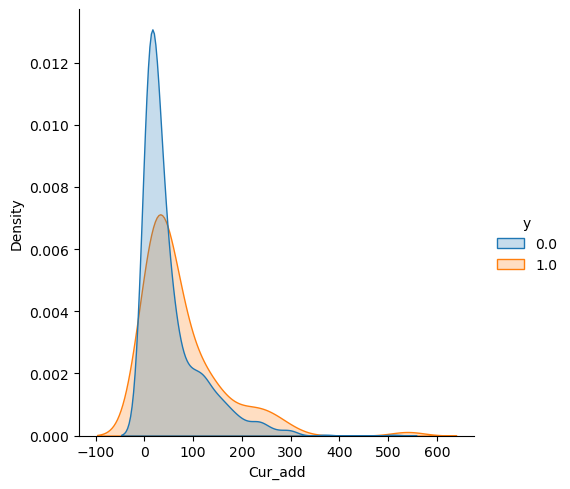

In [87]:
sns.displot(x=(df['Cur_add']), kind="kde", fill=True, hue=dt.y, common_norm=False)
plt.show()

Los malos pagodores se encuentran mas concentrados a la derecha

### Major

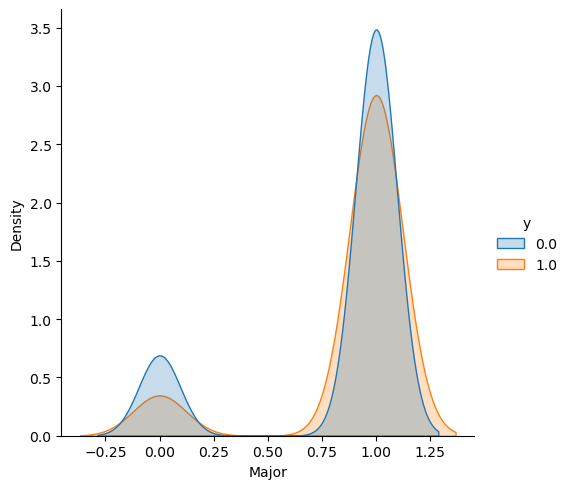

In [88]:
sns.displot(x=(df['Major']), kind="kde", fill=True, hue=dt.y, common_norm=False)
plt.show()

no hay forma de diferenciar con esta variable los buenos de los malos pagadores

### Active

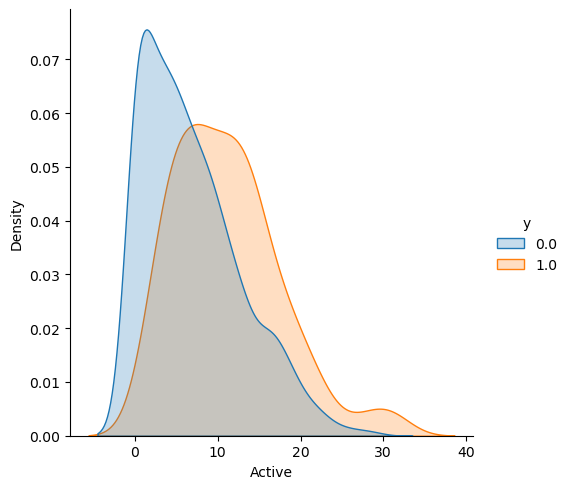

In [89]:
sns.displot(x=(df['Active']), kind="kde", fill=True, hue=dt.y, common_norm=False)
plt.show()

esta variable parece ser bastante util, una probabilidad de ser un mal pagador que aumenta notablemente a medida que el numero de tarjetas activas de creditos aumentan 

### Variables dicotomicas

Ownrent: 1 if owns their home, 0 if rent 
Selfempl: 1 if self employed, 0 if not. 


In [49]:
def analyze_binary_var(data, var, target):
    print(f"\n{'='*50}\nAnálisis para: {var}\n{'='*50}")
    
    
    # Visualización
    plt.figure(figsize=(12, 5))
    
    # Gráfico 1: Distribución general
    plt.subplot(1, 2, 1)
    data[var].value_counts().sort_index().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')
    plt.xticks([0, 1], ['No', 'Sí'], rotation=0)
    
    # Gráfico 2: Relación con default
    plt.subplot(1, 2, 2)
    sns.barplot(x=var, y=target, data=data, estimator=lambda x: sum(x)*100/len(x), ci=None)
    plt.title(f'% Default por categoría de {var}')
    plt.xlabel(var)
    plt.ylabel('Porcentaje de Default (%)')
    plt.xticks([0, 1], ['No', 'Sí'])
    plt.ylim(0, 100)
    
    plt.tight_layout()
    plt.show()
    
    # Cálculo de odds ratio (medida de asociación)
    cross_tab = pd.crosstab(data[var], data[target])
    odds_ratio = (cross_tab.loc[1,1] * cross_tab.loc[0,0]) / (cross_tab.loc[1,0] * cross_tab.loc[0,1])
    print(f"\nOdds Ratio (OR) para {var}: {odds_ratio:.2f}")



Análisis para: Ownrent


C:\Users\pablo\AppData\Local\Temp\ipykernel_15248\2399713789.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=var, y=target, data=data, estimator=lambda x: sum(x)*100/len(x), ci=None)


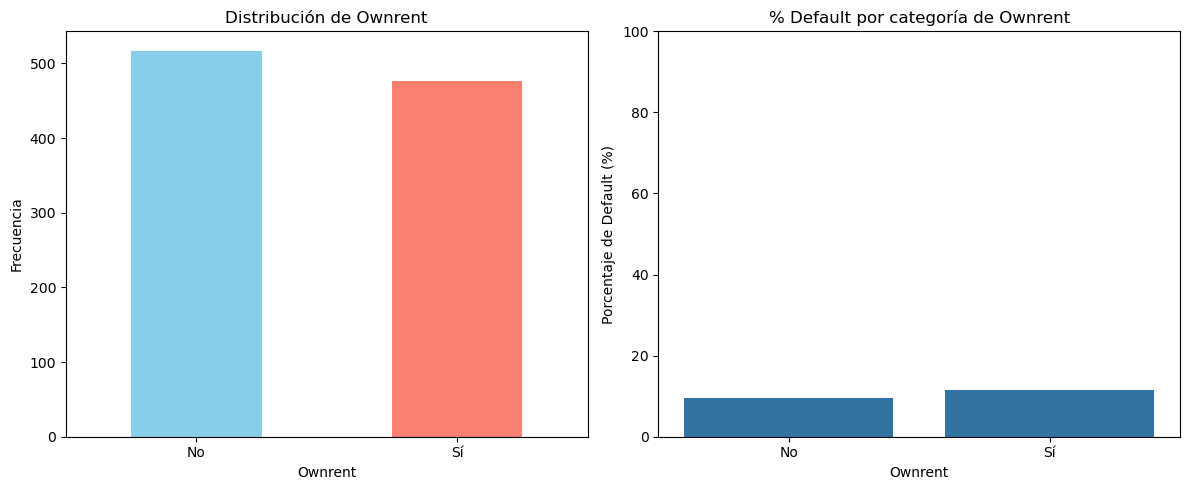


Odds Ratio (OR) para Ownrent: 1.24

Análisis para: Selfempl


C:\Users\pablo\AppData\Local\Temp\ipykernel_15248\2399713789.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=var, y=target, data=data, estimator=lambda x: sum(x)*100/len(x), ci=None)


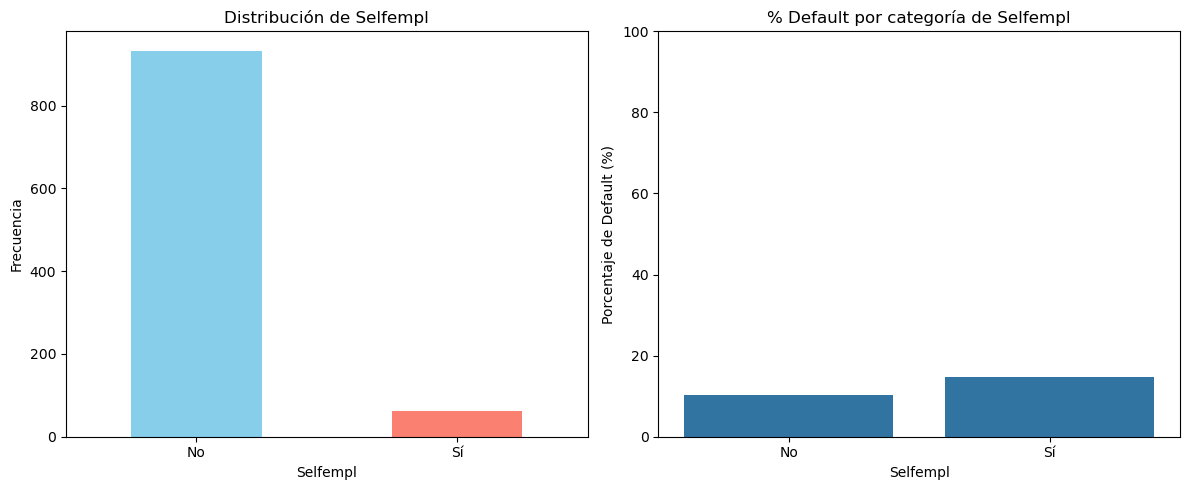


Odds Ratio (OR) para Selfempl: 1.53


In [99]:
binary_vars = ["Ownrent", "Selfempl"]
dt_default_cleaned = dt.dropna(subset=['y'])
for var in binary_vars:
    analyze_binary_var(dt_default_cleaned, var, "y")

Ninguna de las dos muestra una relacion clara con la variable ojetivo el selfempl por ahi aporta algo de informacion. Aguien que es su propio empleador tiene algo 1.53% mas de cometer impago del que no lo es

# Tramificacion y calculo del WOE

In [116]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

df_train, df_test = train_test_split(df,stratify=df["y"], test_size=.25, random_state=1234)

# 1) Definimos la lista de nombres señalando cualse de ellas son las categóricas
Y = df_train['y'].values
X = df_train.drop(columns=['y']) #todas menos la primera que es el ID y la variable y
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()

# 2) Definimos el criterio de selección
selection_criteria = {
    "iv": {"min": 0.02}  # no imponemos "max": 1}
}

# En caso de que desee modificarse los valores por defecto en el proceso de tramificación de alguna variable puede hacerse en forma de diccionario

binning_fit_params={
    "purpose":{"cat_cutoff": 0.10}
}

# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria,
    binning_fit_params=binning_fit_params)

# 4) Obtenemos los tramos optimos de todas las Variables
df_train_binned = binning_process.fit(X, Y)

# Ahora podemos ir sacando las tablas para cada variable

df_train_binned.get_binned_variable("Cardhldr").binning_table.build()
df_train_binned.get_binned_variable("Age").binning_table.build()
df_train_binned.get_binned_variable("Income").binning_table.build()
df_train_binned.get_binned_variable("Avgexp").binning_table.build()
df_train_binned.get_binned_variable("Ownrent").binning_table.build()
df_train_binned.get_binned_variable("Selfempl").binning_table.build()
df_train_binned.get_binned_variable("Depndt").binning_table.build()
df_train_binned.get_binned_variable("Inc_per").binning_table.build()
df_train_binned.get_binned_variable("Major").binning_table.build()
df_train_binned.get_binned_variable("Active").binning_table.build()

df_train_woe=df_train_binned.transform(X, metric="woe")

# Ahora aplicaríamos la misma transformación pero al conjunto de test (si hubiera que puntuar a nuevos clientes haríamos lo mismo)

Y_test = df_test['y'].values
X_test = df_test.drop(columns=['y']) #todas menos la primera que es el ID y la variable y

df_test_woe=df_train_binned.transform(X_test, metric="woe")
df_test_woe.info()


<class 'pandas.core.frame.DataFrame'>
Index: 322 entries, 934 to 482
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        322 non-null    float64
 1   Age       322 non-null    float64
 2   Income    322 non-null    float64
 3   Exp_Inc   322 non-null    float64
 4   Avgexp    322 non-null    float64
 5   Ownrent   322 non-null    float64
 6   Selfempl  322 non-null    float64
 7   Inc_per   322 non-null    float64
 8   Cur_add   322 non-null    float64
 9   Major     322 non-null    float64
 10  Active    322 non-null    float64
dtypes: float64(11)
memory usage: 30.2 KB


In [122]:
# Obtener el resumen estadístico del binning process
binning_summary = binning_process.summary()

# Filtrar solo las columnas relevantes (variable, IV, WOE promedio)
woe_iv_summary = binning_summary[['name', 'iv']].copy()

# Renombrar columnas para claridad
woe_iv_summary.columns = ['Variable', 'IV (Information Value)']

# Mostrar el resultado ordenado por IV (de mayor a menor)
woe_iv_summary_sorted = woe_iv_summary.sort_values('IV (Information Value)', ascending=False)
print(woe_iv_summary_sorted)

    Variable IV (Information Value)
5     Avgexp               3.606384
4    Exp_Inc               3.580383
10   Cur_add                0.14416
3     Income               0.108397
9    Inc_per               0.098669
2        Age               0.051442
0         ID               0.046427
6    Ownrent               0.044179
12    Active               0.041158
7   Selfempl               0.036446
11     Major               0.024164
8     Depndt               0.004044
1   Cardhldr                    0.0
